##### Building a hybrid anomaly detection model combining a sparse autoencoder, Isolation Forest, and SVM begins by loading and cleaning your data. Select key features and split the data into training and testing sets. Normalize the data through feature scaling, which is crucial for the model's accuracy. First, use a sparse autoencoder for dimensionality reduction, making the data more manageable and focused. Then, apply an Isolation Forest to efficiently identify potential outliers, followed by an SVM to refine, and confirm the detection of anomalies with precise boundaries. Evaluate the model's effectiveness using precision, recall, the F1-score, and a confusion matrix. This sequential approach harnesses the strengths of each model component, ensuring comprehensive and effective anomaly detection.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 88302 to 73828
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 50000 non-null  int64  
 1   id.resp_p                 50000 non-null  int64  
 2   flow_duration             50000 non-null  float64
 3   fwd_pkts_tot              50000 non-null  int64  
 4   bwd_pkts_tot              50000 non-null  int64  
 5   fwd_data_pkts_tot         50000 non-null  int64  
 6   bwd_data_pkts_tot         50000 non-null  int64  
 7   fwd_pkts_per_sec          50000 non-null  float64
 8   bwd_pkts_per_sec          50000 non-null  float64
 9   flow_pkts_per_sec         50000 non-null  float64
 10  down_up_ratio             50000 non-null  float64
 11  fwd_header_size_tot       50000 non-null  int64  
 12  fwd_header_size_min       50000 non-null  int64  
 13  fwd_header_size_max       50000 non-null  int64  
 14  bw

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


141/141 [==============================] - 1s 2ms/step - loss: 0.1117 - val_loss: 0.0418
Epoch 2/50
141/141 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0114
Epoch 3/50
141/141 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 4/50
141/141 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 5/50
141/141 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 6/50
141/141 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/50
141/141 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/50
141/141 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/50
141/141 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/50
141/141 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 11/5

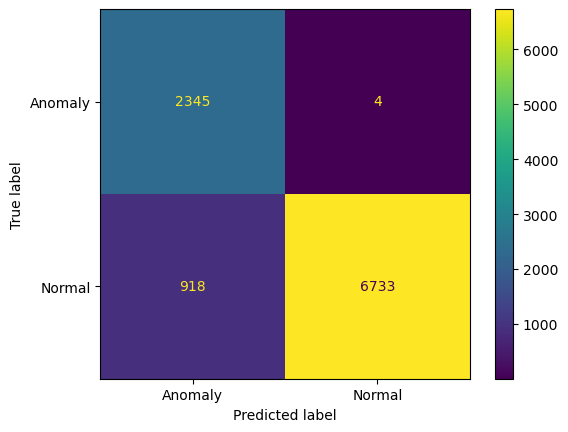

In [11]:

def hybrid_anomaly_detection():
    # Load data from a CSV file
    data1 = pd.read_csv('rt_test.csv')
    
        
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['proto','service','Attack_type'], axis=1)
    data.dropna(axis=0, inplace=True)

    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        
    data.info()
    
    # Preprocessing
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()

    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    
    X = data.drop('payload_bytes_per_second', axis=1)  # Assuming 'label' is your target column
    y_cont = data['payload_bytes_per_second']

    # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > 1000, 1, 0)  # Define `threshold` based on your domain knowledge
   
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Define and train the autoencoder
    input_dim = X_train.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train Isolation Forest on the encoded data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_encoded)
    if_train_labels = iso_forest.predict(X_train_encoded)
    
    # Filter only rows detected as normal
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_encoded[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_normal, y_train_normal)
    
    # Predict on the entire test dataset
    svm_predictions = svm.predict(X_test_encoded)
    
    # Evaluate the model
    precision = precision_score(y_test, svm_predictions, pos_label=1)
    recall = recall_score(y_test, svm_predictions, pos_label=1)
    f1 = f1_score(y_test, svm_predictions, pos_label=1)
    
    
    print(classification_report(y_test, svm_predictions))

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage, assuming the CSV file is correctly formatted and located
hybrid_anomaly_detection()
